In [45]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from time import time

In [46]:
# tensor =tf.constant([[1,2,3],[4,5,6]])

# tensor.numpy()

In [47]:
df_pagamentos= pd.read_csv('dados/payment_data.csv')
df_pagamentos.set_index('id', inplace=True) # seta o id como index
df_consumidores = pd.read_csv('dados/customer_data.csv')
df_consumidores.set_index('id', inplace=True) # seta o id como index

In [48]:
dados_consumidores=df_consumidores.join(df_pagamentos, how='inner') # junta os dois dataframes
dados_consumidores.columns

Index(['label', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7',
       'fea_8', 'fea_9', 'fea_10', 'fea_11', 'OVD_t1', 'OVD_t2', 'OVD_t3',
       'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit', 'update_date',
       'new_balance', 'highest_balance', 'report_date'],
      dtype='object')

In [49]:
colunas=['alvo',
 'caracteristica_1',
 'caracteristica_2',
 'caracteristica_3',
 'caracteristica_4',
 'caracteristica_5',
 'caracteristica_6',
 'caracteristica_7',
 'caracteristica_8',
 'caracteristica_9',
 'caracteristica_10',
 'caracteristica_11',
 'atraso_t1',
 'atraso_t2',
 'atraso_t3',
 'atraso_total',
 'pagemento_normal',
 'codigo_produto',
 'limite_credito',
 'data_atualizada',
 'saldo_atual_produto',
 'saldo_mais_alto_produto',
 'report_date']


dados_consumidores.columns=colunas
dados_consumidores.to_excel('dados/dados_consumidores.xlsx')


In [50]:
dados_consumidores['alvo'].value_counts() # conta quantas vezes cada label aparece

0    6863
1    1387
Name: alvo, dtype: int64

In [51]:
dados_consumidores.isnull().sum() # conta quantos valores faltantes

alvo                          0
caracteristica_1              0
caracteristica_2           1028
caracteristica_3              0
caracteristica_4              0
caracteristica_5              0
caracteristica_6              0
caracteristica_7              0
caracteristica_8              0
caracteristica_9              0
caracteristica_10             0
caracteristica_11             0
atraso_t1                     0
atraso_t2                     0
atraso_t3                     0
atraso_total                  0
pagemento_normal              0
codigo_produto                0
limite_credito             6118
data_atualizada              26
saldo_atual_produto           0
saldo_mais_alto_produto     409
report_date                1114
dtype: int64

In [52]:
dados_consumidores['codigo_produto'].value_counts() # conta quantas vezes cada categoria aparece


10    4523
6     1144
5      962
1      427
13     425
2      239
0      147
7      147
12      56
19      35
8       24
24      24
17      22
15      22
3       21
26      14
25       5
4        4
27       3
22       3
9        3
Name: codigo_produto, dtype: int64

In [53]:
for prod_code in dados_consumidores["codigo_produto"].unique():
    
    dados_consumidores["codigo_produto{}".format(prod_code)] = dados_consumidores["codigo_produto"] == prod_code
    
dados_consumidores.columns



Index(['alvo', 'caracteristica_1', 'caracteristica_2', 'caracteristica_3',
       'caracteristica_4', 'caracteristica_5', 'caracteristica_6',
       'caracteristica_7', 'caracteristica_8', 'caracteristica_9',
       'caracteristica_10', 'caracteristica_11', 'atraso_t1', 'atraso_t2',
       'atraso_t3', 'atraso_total', 'pagemento_normal', 'codigo_produto',
       'limite_credito', 'data_atualizada', 'saldo_atual_produto',
       'saldo_mais_alto_produto', 'report_date', 'codigo_produto10',
       'codigo_produto1', 'codigo_produto2', 'codigo_produto27',
       'codigo_produto6', 'codigo_produto12', 'codigo_produto5',
       'codigo_produto13', 'codigo_produto17', 'codigo_produto0',
       'codigo_produto7', 'codigo_produto22', 'codigo_produto8',
       'codigo_produto19', 'codigo_produto24', 'codigo_produto15',
       'codigo_produto3', 'codigo_produto25', 'codigo_produto4',
       'codigo_produto26', 'codigo_produto9'],
      dtype='object')

In [54]:
dados_consumidores['caracteristica_4'].unique()

array([1000000., 1200000.,  286000.,   70000.,  120000.,   30000.,
        325000.,   77000.,  130000.,   90000.,  157000.,  154000.,
        102000.,  163000.,   88000.,  132000.,   82000.,  117000.,
         58000.,   78000.,  270000.,   72000.,   89000.,  114000.,
        180000.,  220000.,   56000.,   35000.,  127000.,  104000.,
         47000.,  143000.,  195000.,  106000.,   96000.,  125000.,
         94000.,   59000.,  110000.,   54000.,   76000.,   83000.,
         57000.,  144000.,   79000.,  134000.,   51000.,   81000.,
        112000.,   80000.,  155000.,   91000.,   61000.,  111000.,
        100000.,  167000.,   60000.,   15000.,   50000.,  227000.,
         66000.,   68000.,   71000.,  121000.,   63000.,  193000.,
        187000.,  183000.,   97000.,  290000.,  115000.,  150000.,
         93000.,  140000.,  162000.,   98000.,  203000.,  149000.,
        312000.,  264000.,  108000.,  243000.,  500000.,   73000.,
        116000.,  379000.,  173000.,  137000.,  263000.,  1380

In [55]:
for feature_id in [1, 3, 5, 6, 7, 9]:
    for value in dados_consumidores["caracteristica_{}".format(feature_id)].unique():
        dados_consumidores["caracteristica_{}_{}".format(feature_id, value)] = dados_consumidores["caracteristica_{}".format(feature_id)] == value
dados_consumidores


,alvo,caracteristica_1,caracteristica_2,caracteristica_3,caracteristica_4,caracteristica_5,caracteristica_6,caracteristica_7,caracteristica_8,caracteristica_9,...,caracteristica_7_10,caracteristica_7_8,caracteristica_7_3,caracteristica_7_4,caracteristica_7_1,caracteristica_9_5,caracteristica_9_3,caracteristica_9_4,caracteristica_9_1,caracteristica_9_2
id,,,,,,,,,,,,,,,,,,,,,
54982353,0,1,1130.0,2,1000000.0,2,4,-1,100,5,...,False,False,False,False,False,True,False,False,False,False
54982353,0,1,1130.0,2,1000000.0,2,4,-1,100,5,...,False,False,False,False,False,True,False,False,False,False
54982353,0,1,1130.0,2,1000000.0,2,4,-1,100,5,...,False,False,False,False,False,True,False,False,False,False
54982353,0,1,1130.0,2,1000000.0,2,4,-1,100,5,...,False,False,False,False,False,True,False,False,False,False
54982353,0,1,1130.0,2,1000000.0,2,4,-1,100,5,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59006219,0,4,NaN,2,111000.0,2,8,5,110,4,...,False,False,False,False,False,False,False,True,False,False
59006219,0,4,NaN,2,111000.0,2,8,5,110,4,...,False,False,False,False,False,False,False,True,False,False
59006239,0,7,1322.0,3,68000.0,2,11,5,86,3,...,False,False,False,False,False,False,True,False,False,False


In [56]:
dados_consumidores = dados_consumidores.drop(["limite_credito", "report_date", 
                                              "data_atualizada", "codigo_produto", 
                                              "caracteristica_1", "caracteristica_3", 
                                              "caracteristica_5", "caracteristica_6",
                                              "caracteristica_7", "caracteristica_9"], 
                                             axis=1)

In [57]:
dados_consumidores_array_np = dados_consumidores.to_numpy(na_value=np.nan).astype(float)

In [58]:


#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = SimpleImputer(verbose=2)
data = imputer.fit_transform(dados_consumidores_array_np)

# (dados_consumidores==np.nan).any()
# print(imp_mean)

In [59]:
scaler = MinMaxScaler()

dados_consumidores_normalizado =scaler.fit_transform(data)

dados_consumidores_normalizado

array([[0.        , 0.03703704, 0.83122363, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03703704, 0.83122363, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03703704, 0.83122363, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.56378601, 0.04472574, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.56378601, 0.04472574, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.56378601, 0.04472574, ..., 0.        , 0.        ,
        0.        ]])

In [60]:
# balanceado o base de dados
mask = dados_consumidores_normalizado[:, 0] == 1
risk_customers = dados_consumidores_normalizado[mask]
print("numero de clientes com risco de crédito alto = {}".format(risk_customers.shape[0]))

safe_customers = dados_consumidores_normalizado[~mask]
indices = np.random.choice(safe_customers.shape[0], risk_customers.shape[0]*2, replace=False)
safe_customers = safe_customers[indices]
print("numero de clientes com risco de crédito baixo = {}".format(safe_customers.shape[0]))

dados_consumidores_normalizado = np.concatenate([risk_customers, safe_customers], axis=0)
print("tamanho do novo dataframe = ", dados_consumidores_normalizado.shape)

numero de clientes com risco de crédito alto = 1387
numero de clientes com risco de crédito baixo = 2774
tamanho do novo dataframe =  (4161, 70)


In [61]:

X=dados_consumidores_normalizado[:,1:]  # features
y=dados_consumidores_normalizado[:,0] #label 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)



In [67]:

def create_model(optimizer='adam'):

    model =tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=69, input_shape=(69,)))
    model.add(tf.keras.layers.Dense(36, activation='relu'))
    model.add(tf.keras.layers.Dense(18, activation='relu'))
    model.add(tf.keras.layers.Dense(9, activation='relu'))

    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

model=create_model()
# model = KerasClassifier(build_fn=create_model, verbose=1)

# optimizers = ['rmsprop','adam']
# epochs = np.array([10])
# batches = np.array([32])

# param_grid= dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
# grid= GridSearchCV(estimator=model, param_grid=param_grid)

# start=time()
# grid_result = grid.fit(X_train, y_train)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# for params, mean_score, scores in grid_result.grid_scores_:
#     print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
# print("total time:",time()-start)

In [68]:
model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1)
model.evaluate(X_test, y_test, verbose=0)

Epoch 1/1000
88/88 [==============================] - 1s 3ms/step - loss: 0.6247 - accuracy: 0.6735
Epoch 2/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6807
Epoch 3/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.5740 - accuracy: 0.7076
Epoch 4/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.7298
Epoch 5/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.5326 - accuracy: 0.7438
Epoch 6/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.5207 - accuracy: 0.7445
Epoch 7/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.5042 - accuracy: 0.7607
Epoch 8/1000
88/88 [==============================] - 0s 2ms/step - loss: 0.4916 - accuracy: 0.7675
Epoch 9/1000
88/88 [==============================] - 0s 2ms/step - loss: 0.4878 - accuracy: 0.7696
Epoch 10/1000
88/88 [==============================] - 0s 2ms/step - loss: 0.4685 - accuracy: 0.7826

[1.581620454788208, 0.8617176413536072]

In [84]:


yk=model.predict(X_test)
# resposta=np.argmax(yk, axis=-1)


score=model.evaluate(X_test, y_test)
resposta=np.array([1 if yk[i]>0.5 else 0 for i in range(len(yk))])
bons_pagadores=resposta==0 

print("Bom pagador",resposta[bons_pagadores].shape[0])
print("Mau pagador",resposta[~bons_pagadores].shape[0])


# resp=np.array(resposta).reshape(-1,1)
# alvo=np.array(y_test).reshape(-1,1)
# comparativo=np.append(alvo,resp,axis=1)


# df_saida=pd.DataFrame(comparativo, columns=['alvo','previsto'])

# df=pd.DataFrame(data=resposta, index=y_test, columns=['label'])
# df.loc[df['label']==1,'label']='Mau pagador'
# df.loc[df['label']==0,'label']='Bom pagador'


43/43 [==============================] - 1s 4ms/step - loss: 1.5816 - accuracy: 0.8617
Bom pagador 887
Mau pagador 487


In [65]:
# # balance the dataset
# mask = dados_teste[:, 0] == 1

# risk_customers = dados_teste[mask]
# print("number of risk customers = {}".format(risk_customers.shape[0]))

# safe_customers = dados_teste[~mask]
# indices = np.random.choice(safe_customers.shape[0], risk_customers.shape[0]*2, replace=False)

# safe_customers = safe_customers[indices]
# print("number of safe customers = {}".format(safe_customers.shape[0]))

# data = np.concatenate([risk_customers, safe_customers], axis=0)
# print("Shape of selected data = ", dados_teste.shape)ll

<AxesSubplot:>

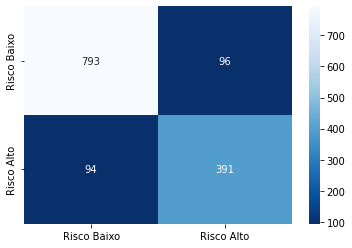

In [85]:
from sklearn.metrics import confusion_matrix
classes = ['Risco Baixo','Risco Alto']
CM = confusion_matrix(y_test, resposta)


# Visualize it as a heatmap
import seaborn
seaborn.heatmap(CM, annot=True,  fmt='d', cmap='Blues_r', xticklabels=classes, yticklabels=classes)



